In [36]:
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


ROOT = "./data/gender/train"
BATCH_SIZE = 200
LATENT_SIZE = 100
train_ds = ImageFolder(ROOT, tt.Compose([tt.RandomHorizontalFlip(),tt.ToTensor()]))
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=1, num_workers=2, pin_memory=1)

In [37]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [38]:
import torch.nn as nn

class Cnn10(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv15 = nn.Conv2d(3,15,3,1,1)
        
        self.conv75a =  nn.Conv2d(15,75,3,2,1)
        self.conv75b =  nn.Conv2d(75,75,3,1,1)
        self.conv75c =  nn.Conv2d(75,75,3,1,1)
        
        self.conv150a = nn.Conv2d(75,150,3,2,1)
        self.conv150b = nn.Conv2d(150,150,3,1,1)
        self.conv150c = nn.Conv2d(150,150,3,1,1)
        
        self.conv300a = nn.Conv2d(150,300,3,2,1)
        self.conv300b = nn.Conv2d(300,300,3,1,1)
        self.conv300c = nn.Conv2d(300,300,3,1,1)
        
        self.aapool = nn.AvgPool2d(2,2)
        
        self.flat = nn.Flatten()
        self.leak = nn.LeakyReLU(0.2)

        self.linear1 = nn.Linear(1800,300)
        self.linear2 = nn.Linear(300,1)
    
    def forward(self,data):
        
        out = self.leak(self.conv15(data))

        out = self.leak(self.conv75a(out))
        out = self.leak(self.conv75b(out))
        out = self.leak(self.conv75c(out))

        out = self.leak(self.conv150a(out))
        out = self.leak(self.conv150b(out))
        out = self.leak(self.conv150c(out))

        out = self.leak(self.conv300a(out))
        out = self.leak(self.conv300b(out))
        out = self.leak(self.conv300c(out))       
        
        out = self.aapool(out)
        out = self.aapool(out)
        
        out = self.flat(out)
        
        out = self.linear1(out)
        out = self.leak(out)
        out = self.linear2(out)

        out = torch.sigmoid(out)
        return out

D = Cnn10().to(device)

In [39]:
rand = torch.randn(BATCH_SIZE,LATENT_SIZE,3,2)

G = nn.Sequential(
    nn.ConvTranspose2d(100,360,kernel_size=4,stride=2,padding=1),
    nn.BatchNorm2d(360),
    nn.ReLU(),
    nn.ConvTranspose2d(360,180,kernel_size=4,stride=2,padding=1),
    nn.BatchNorm2d(180),
    nn.ReLU(),
    nn.ConvTranspose2d(180,180,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(180,90,kernel_size=4,stride=2,padding=1),
    nn.BatchNorm2d(90),
    nn.ReLU(),
    nn.ConvTranspose2d(90,30,kernel_size=4,stride=2,padding=1),
    nn.BatchNorm2d(30),
    nn.ReLU(),
    nn.ConvTranspose2d(30,3,kernel_size=4,stride=2,padding=1),
    nn.Tanh()
)

G = G.to(device)

In [40]:
loss_fn = nn.BCELoss()
d_opt = torch.optim.Adam(D.parameters(), lr=0.00001)
g_opt = torch.optim.Adam(G.parameters(), lr=0.0001)

In [41]:
real_labels = torch.ones(BATCH_SIZE,1).to(device)
fake_labels = torch.zeros(BATCH_SIZE,1).to(device)

def d_fit(real_images):
    d_opt.zero_grad()

    real_preds = D(real_images)
    real_d_loss = loss_fn(real_preds, real_labels)

    rand = torch.randn(BATCH_SIZE, LATENT_SIZE,3,2).to(device)
    fake_images = G(rand)
    fake_preds = D(fake_images)
    fake_d_loss = loss_fn(fake_preds, fake_labels)
    
    d_loss = real_d_loss + fake_d_loss
    
    d_loss.backward()
    
    d_opt.step()
    

    return d_loss,real_preds,fake_preds

In [42]:
def g_fit():
    g_opt.zero_grad()
    
    rand = torch.randn(BATCH_SIZE, LATENT_SIZE).to(device)
    fake_images = G(rand)
    g_loss = loss_fn(D(fake_images), real_labels)
    

    g_loss.backward()
    
    g_opt.step()
    
    return g_loss

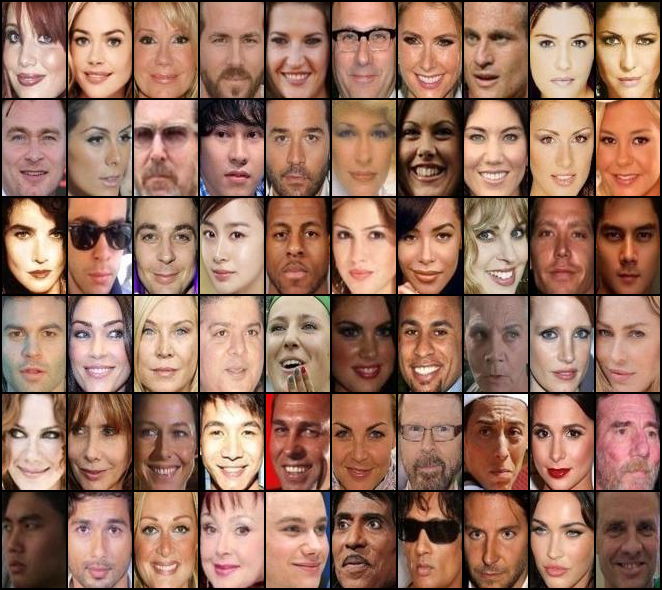

In [43]:
from IPython.display import Image
from torchvision.utils import save_image

# for images,labels in train_dl:
#     save_image(images[0:60],"./data/gender/gans_data/real_images.png",nrow=10)
#     break

Image("./data/gender/gans_data/real_images.png")

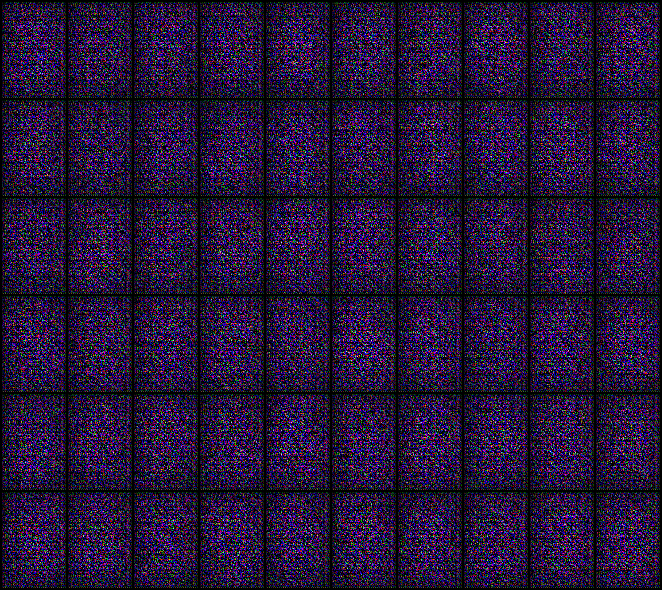

In [45]:
rand = torch.randn(BATCH_SIZE,LATENT_SIZE,3,2).to(device)

def save_fake_images(index):
    fake_images = G(rand)
    save_image(fake_images[0:60], "./data/gender/gans_data/fake_images_"+str(index)+".png", nrow=10)

# save_fake_images(0)
Image("./data/gender/gans_data/fake_images_0.png")

In [ ]:
epochs = 0

torch.cuda.empty_cache()

for epoch in range(epochs):
    
    for images in train_dl:
        
        real_images = images.to(device)
        # print(real_images.shape)
        
        d_loss,real_pred,fake_pred = d_fit(real_images)
        g_loss = g_fit()

    if real_pred.mean()>0.8:
        g_fit()
        g_fit()
    elif real_pred.mean()>0.7:
        g_fit()
    if fake_pred.mean()>0.45:
        d_fit(real_images)
        
    print("Epoch:",epoch+1)
    print("D Loss:",round(d_loss.item(),4),"    G Loss:",round(g_loss.item(),4))
    print("Real_Pred:",round(real_pred.mean().item(),4),"    Fake_Pred:",round(fake_pred.mean().item(),4))
    save_fake_images(epoch+1)